Install libraries

In [ ]:
!pip install -r requirements.txt

# Simulator

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *
from dispatch.dispatch import Dispatch
from simulator.base_simulator import BaseSimulator
from simulator.graphics import plot_CR, plot_counts

# import importlib
# importlib.reload(utils)

Let's firstly 2 main objects of the project:
* dispatch - the box, that assigns couriers on orders
* simulator - a virtual environment that simulates the real world

You can configure the simulator parameters in `environment_config.json` file

In [10]:
dsp = Dispatch() 
sim = BaseSimulator(dsp, step=0.5) # the step is the distance which courier makes for each iteration of dispatch

The code below visualizes per-iteration snapshots of all active routes

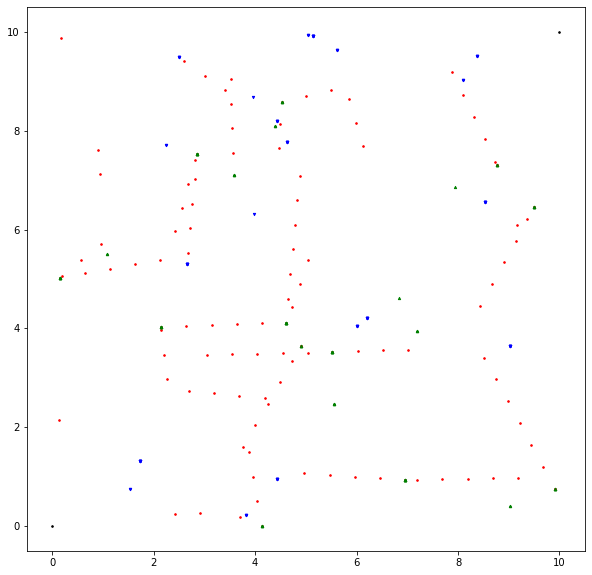

In [11]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
sim.corner_bounds[0].plot(ax, color='black')
sim.corner_bounds[1].plot(ax, color='black')

all_metrics = []
for i in range(10): # run simulator for 10 iterations
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()
    for ar in sim.active_routes:
        ar.plot(ax)

Also, we can see by-iterations statistics of the whole simulation

In [12]:
pd.DataFrame(all_metrics).set_index('iter')

,completed_orders,finished_orders,current_free_couriers,current_free_orders,current_active_routes,total_eta
iter,,,,,,
0,0,0,20,0,0,0.000000
1,0,0,18,0,2,3.575358
2,0,0,16,0,4,4.094119
3,0,0,14,0,6,2.105453
4,0,0,12,0,8,5.276146
5,0,0,10,0,10,4.404964
6,0,0,8,0,12,1.397433
7,0,0,6,0,14,4.818819
8,0,0,4,0,16,7.092518


Let's run the simulation for longer time and see the convergence of bussiness metrics

In [13]:
all_metrics = []
for i in range(2000): # run simulator for 10 iterations
    metrics = sim.GetMetrics()
    all_metrics.append(metrics)
    sim.Next()

micro average CR:  0.652886694236425
macro average CR:  0.645610853075414


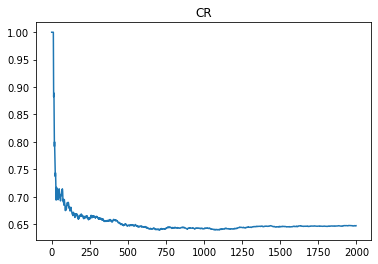

current free couriers:  0.0
current free orders:  13.056
current active routes:  20.0


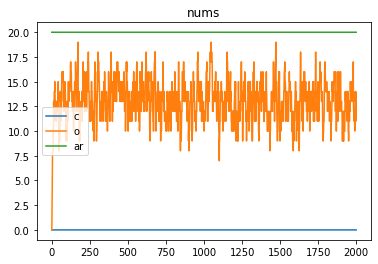

In [14]:
plot_CR(all_metrics)
plot_counts(all_metrics)

Also, we can view some dispatch statistics - more technical metrics

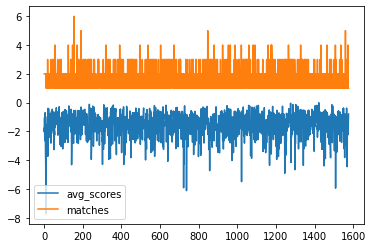

In [15]:
plt.plot(sim.dispatch.statistics['avg_scores'], label='avg_scores')
plt.plot(sim.dispatch.statistics['num_assignments'], label='matches')
plt.legend()
plt.show()

# Neural-network-based dispatch

The idea is to use NNs in dispatch to solve the assignment problem.

Let's firstly decompose the problem

## Positional encoder

Every point is individual. In some areas there can be many orders (because for example there is a storage of big compaby). In some areas there may be bad roads, some the couriers are rare there. That means that we need to encode each point into emdeddings. The PositionalEncoder will do it.

It is trained on the problem of prediction a distance between 2 random points. Embeddings of these points are concated and then followed by linear layer. 

The training code is below

log-losses:  [31.801849212646484, 31.4597487449646, 31.821333541870118, 30.365452404022218, 30.27077646255493]


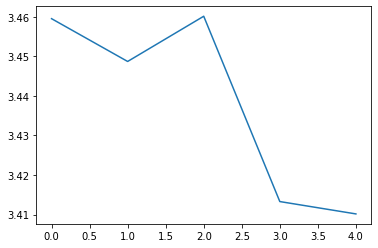

In [19]:
from objects.point import Point, get_random_point
from networks.points_distance_net import PointDistNet
from objects.utils import distance
from IPython.display import clear_output

batch_size = 64
n_epochs = 5
n_iters = 100
bounds = (Point(0, 0), Point(10, 10))
device = None #torch.device('cuda:0')

net = PointDistNet(64, 128, device)
scorer = ETAScoring()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, epochs=n_epochs, steps_per_epoch=n_iters)

losses = []
for epoch in range(n_epochs):
    rolling_loss = []
    for iter in range(n_iters):
        real_distances = []
        pts1 = []
        pts2 = []
        for _ in range(batch_size):
            p1 = get_random_point(bounds)
            p2 = get_random_point(bounds)
            pts1.append(p1)
            pts2.append(p2)
            real_distances.append(distance(p1, p2))

        optimizer.zero_grad()
        mse_loss = nn.MSELoss()
        preds = net(pts1, pts2)
        loss = mse_loss(preds, torch.tensor(real_distances, device=net.device))
        loss.backward()
        optimizer.step()

        rolling_loss.append(loss.item())

    losses.append(np.mean(rolling_loss))
    if epoch % 1 == 0:
        clear_output()
        print('log-losses: ', losses[-50:])
        plt.plot(np.log(losses))
        plt.show()

I trained the model till 0.01-loss convergence. I think that more precision is useless because of overfitting on the exact problem.

In [4]:
import torch
from networks.encoders import PointEncoder
from objects.point import Point, get_random_point
device = torch.device('cpu')
pe = PointEncoder(64, device=device)
pe.load_state_dict(torch.load('pretrained_models/point_encoder64/point_encoder64.pt', map_location=device))

random_point = get_random_point()
embedding = pe(random_point)
print('embedding shape:', embedding.shape)
print('point embedding:', embedding)

embedding shape: torch.Size([64])
point embedding: tensor([ 0.9591, -0.9928, -0.8638,  0.3912,  0.8134, -0.9457, -0.9223,  0.2196,
         0.4088, -0.3766, -0.0237, -0.9824,  0.7664,  0.9947,  0.9416, -0.9989,
        -0.6251, -0.5408, -0.9117,  0.9258, -0.9140, -0.6250, -0.2495, -0.6596,
         0.1941, -0.4378, -0.5329, -0.9989, -0.1660,  0.3313,  0.9114, -0.9399,
        -0.9649, -0.9774, -0.5289, -0.1337, -0.9969, -0.6308,  0.4810, -0.0154,
         0.3818,  0.6911,  0.3756,  0.4150, -0.5642,  0.6101, -0.7954,  0.6954,
        -0.9984, -0.1336, -0.8200, -0.9999,  0.3275,  0.9254, -0.9906, -0.5371,
         0.0275,  0.2973,  0.8066, -0.5628,  0.2780,  0.0167, -0.6116,  0.7915])
